In [5]:
import matplotlib.pyplot as plt
import sys
sys.path.append("/idiap/temp/vpocard/ImageNetTF/More_classes/")
sys.path.append("/idiap/temp/vpocard/ImageNetTF/More_classes/priors/")

import numpy as np

import torch

from torch import nn

# regularization conv1= [2. 5.]
# regularization conv2= [3. 5.]
# regularization conv3= [3. 2.]
# regularization conv4= [4. 5.]
# conv ,L2w ,Hw = 1 , 2,5
# conv ,L2w ,Hw = 2 , 3,5

# conv ,L2w ,Hw = 3 , 3,2
conv ,L2w ,Hw = 4 , 4,5
numBin = 20

run = 2
modelChoice = 1

/idiap/temp/vpocard/ImageNetTF/More_classes/Experiment/ResultHessian/Conv4/4.0/5.0_penal_model_run_2
num zero center= tensor(89719)
num zero diag= tensor(770)
tensor(0.)
num zero newTheta= tensor(89719)
diag shape= torch.Size([119244])
newTheta shape= torch.Size([119244])
center shape= torch.Size([119244])


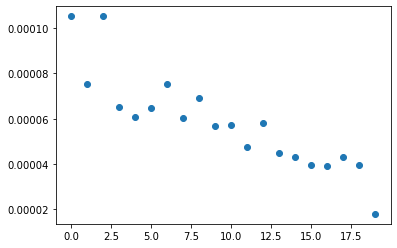

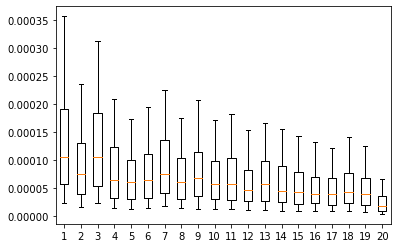

In [6]:

device = "cpu"
hessianApprox = torch.load(f"/idiap/temp/vpocard/ImageNetTF/More_classes/Experiment/Hessians/conv{conv}Compiled",map_location=device)
# hessianApprox = torch.load("/idiap/temp/vpocard/ImageNetTF/More_classes/SS-learning/Hessian/hessianCompiled2",map_location=device)

models = [f"/idiap/temp/vpocard/ImageNetTF/More_classes/Experiment/ResultId/Conv{conv}/3.0_penal_model_run_{run}",f"/idiap/temp/vpocard/ImageNetTF/More_classes/Experiment/ResultHessian/Conv{conv}/{L2w}.0/{Hw}.0_penal_model_run_{run}"]
print(models[modelChoice])
hessModel = torch.load(models[modelChoice],map_location=device)

center = hessianApprox.SubHessianList[0][0].mean
print("num zero center=",sum(center==0))

W = hessianApprox.SubHessianList[0][0].W.cpu()
# W = W[:,center.cpu()!=0]
W = W*hessianApprox.SubHessianList[0][0].eigen[...,None].cpu()
diag = W.square().sum(dim=0).view(-1)

hessianApprox = torch.load("/idiap/temp/vpocard/ImageNetTF/More_classes/SS-learning/Hessian/EWC",map_location=device)
diag = hessianApprox.SubHessianList[0][0].diag
diag = diag[:len(center)]

print("num zero diag=",sum(diag==0))
print(center[diag==0].sum())
# hessian = torch.mm(W.T,W).numpy()
# print("w shape = ", W.shape)
# print("W norm=",W.norm(dim=1))
# print("hessian shape = ", hessian.shape)
# print("hessian min" = hessian)
# plt.imshow(hessian,cmap="magma")
# plt.show()


# mask = center != 0

# diag = diag[mask]


newTheta = []
numelem= 0
for convNumber in range(1,1+conv):
    layer = hessModel.__getattr__(f"conv_stack{convNumber}")
    for p in layer.parameters():
        numelem += p.numel() 
        newTheta.append(p.view(-1))
newTheta = torch.cat(newTheta)
print("num zero newTheta=",sum(newTheta==0))
print("diag shape=",diag.shape)
print("newTheta shape=",newTheta.shape)

print("center shape=",center.shape)

nonZeroIndices = newTheta !=0

newTheta = newTheta[nonZeroIndices].detach()
center = center[nonZeroIndices]
diag = diag[nonZeroIndices]

binSize = int( np.floor( len(diag)/numBin))
start = len(diag) -binSize*numBin
topk = torch.topk(diag,k=  binSize*numBin)
indices = []
for bin in range(numBin):
    indices.append(topk.indices[bin*binSize:(bin+1)*binSize])

weightChange = []
means = []
stds = []
for indice in indices:
    pStart = center[indice]
    pChange = newTheta[indice]
    relativeChange = ((pStart-pChange)).square()#/pStart

    # relativeChange = ((pStart-pChange)/pStart).square()#/pStart
    q = torch.tensor([0.25,0.75]).to(device)
    lowerB,higherB = relativeChange.quantile(q)
    extractIndice = torch.logical_and(relativeChange>lowerB , relativeChange < higherB) 
    relativeChange = relativeChange[extractIndice]
    # means.append(relativeChange.mean().cpu().numpy())
    means.append(relativeChange.median().cpu().numpy())
    stds.append(relativeChange.std().cpu().numpy())
    weightChange.append( relativeChange.cpu().numpy()  )
# weightChange = np.array(weightChange)

# plt.errorbar(range(numBin),means,stds)
plt.scatter(range(numBin),means)

plt.show()
plt.boxplot(weightChange)
plt.show()
